# Propagating LANDSAT DATA

In [13]:
# python imports
import numpy as np
import matplotlib.pyplot as plt
import datetime
import orekit
import logging
import math
import cartopy.crs as ccrs

## Orekit Imports
Keep all orekit imports below.

In [14]:
# orekit imports
from orekit.pyhelpers import setup_orekit_curdir, absolutedate_to_datetime, datetime_to_absolutedate
from org.hipparchus.geometry.euclidean.threed import Line
from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.orekit.utils import Constants, PVCoordinates, ExtendedPVCoordinatesProvider
from org.orekit.bodies import CelestialBodyFactory, OneAxisEllipsoid, GeodeticPoint
from org.orekit.frames import FramesFactory, TopocentricFrame
from org.orekit.time import TimeScalesFactory
from org.orekit.orbits import KeplerianOrbit, PositionAngle, OrbitType, CircularOrbit, EquinoctialOrbit
from org.orekit.propagation import SpacecraftState, PropagatorsParallelizer
from org.orekit.propagation.numerical import NumericalPropagator
from org.hipparchus.ode.nonstiff import DormandPrince853Integrator
from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel, ThirdBodyAttraction
from org.orekit.forces.gravity.potential import GravityFieldFactory
from org.orekit.forces.drag import IsotropicDrag, DragForce
from org.orekit.forces.radiation import IsotropicRadiationClassicalConvention, SolarRadiationPressure
from org.orekit.models.earth.atmosphere import HarrisPriester
from org.orekit.utils import IERSConventions
from org.orekit.propagation.events import EclipseDetector, EventDetector, ElevationDetector
from org.orekit.propagation.sampling import PythonOrekitFixedStepHandler
from org.orekit.propagation.events.handlers import EventHandler, PythonEventHandler
from org.orekit.propagation.events.handlers import ContinueOnEvent
from org.hipparchus.ode.events import Action
from org.orekit.forces import BoxAndSolarArraySpacecraft
from orekit import JArray_double


## Set up Orekit

In [15]:
vm = orekit.initVM()
setup_orekit_curdir("../../../orekit-data.zip")

In [16]:
def eci2kep(r, v, mu):
    h = np.cross(r, v)
    n = np.cross(np.array([0, 0, 1]), h)
    e_vec = ((np.linalg.norm(v)**2 - mu/(np.linalg.norm(r)))*r - np.dot(r, v)*v)/mu
    e = np.linalg.norm(e_vec)
    assert e < 1.0
    energy = (np.linalg.norm(v)**2)/2 - mu/(np.linalg.norm(r))
    sma = -mu/(2*energy)
    p = sma*(1 - e**2)
    inclination = np.arccos(h[2]/np.linalg.norm(h))
    raan = np.arccos(n[0]/np.linalg.norm(n))
    perigee = np.dot(n, e_vec)/(np.linalg.norm(n)*e)
    nu = np.dot(e_vec, r)/(e*np.linalg.norm(r))
    return [sma, e, inclination, raan, perigee, nu]


In [17]:
import csv
data = []
times = []
keps = []
with open('01Jan2021.txt') as csvfile:
    reader = csv.reader(csvfile)
    i = 0
    for row in reader:
        if i > 2:
            pv = [float(v) for v in row[1:]]
            data.append(pv)
            times.append(datetime.datetime.strptime(row[0], "%j/%Y %H:%M:%S.%f"))
            keps.append(eci2kep(np.array(pv[:3]), np.array(pv[3:]), 3.98600442e5))
        i += 1


In [18]:
data = np.array(data)
keps= np.array(keps)

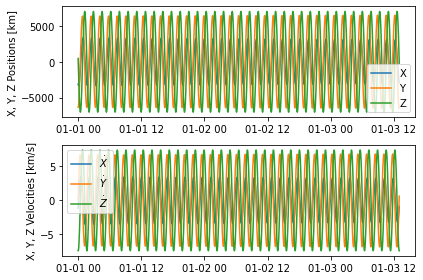

In [19]:
f = plt.figure("Position Velocity 2.5 days")
ax_pos = f.add_subplot(211)
ax_pos.plot(times, data[:, :3])
ax_pos.set_ylabel("X, Y, Z Positions [km]")
ax_pos.legend(["X", "Y", "Z"])
ax_vel = f.add_subplot(212)
ax_vel.plot(times, data[:,3:])
ax_vel.set_ylabel("X, Y, Z Velocities [km/s]")
ax_vel.legend([r"$\dot{X}$", r"$\dot{Y}$", r"$\dot{Z}$"])

plt.tight_layout()

In [20]:
f_kep_25 = plt.figure("Orbital Elements 2.5 Days")
ax_sma = f_kep_25.add_subplot(611)
ax_sma.plot(times, keps[:, 0])
ax_sma.set_ylabel("Semi-Major Axis [km]")


ax_ecc = f.add_subplot(612)
ax_ecc.plot(times, keps[:, 1])
ax_ecc.set_ylabel("Eccentricity")

ax_inc = f.add_subplot(613)
ax_inc.plot(times, np.rad2deg(keps[:, 2]))
ax_inc.set_ylabel("Inclination [deg]")


ax_raan = f.add_subplot(614)
ax_raan.plot(times, np.rad2deg(keps[:, 3]))
ax_raan.set_ylabel("RAAN [deg]")


ax_perigee = f.add_subplot(615)
ax_perigee.plot(times, np.rad2deg(keps[:, 4]))
ax_perigee.set_ylabel("Perigee [deg]")

ax_nu = f.add_subplot(616)
ax_nu.plot(times, np.rad2deg(keps[:, 5]))
ax_nu.set_ylabel("True Anomaly [deg]")
plt.tight_layout()


In [21]:
import csv
data = []
times = []
keps = []
with open('7days.txt') as csvfile:
    reader = csv.reader(csvfile)
    i = 0
    for row in reader:
        if i > 2:
            pv = [float(v) for v in row[1:]]
            data.append(pv)
            times.append(datetime.datetime.strptime(row[0], "%j/%Y %H:%M:%S.%f"))
            keps.append(eci2kep(np.array(pv[:3]), np.array(pv[3:]), 3.98600442e5))
        i += 1


In [22]:
data = np.array(data)
keps= np.array(keps)

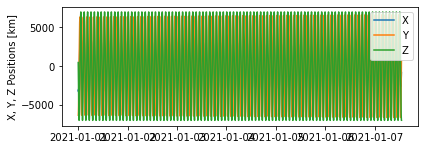

In [23]:
f_pv_7 = plt.figure("Position Velocity 7 days")
ax_pos_7 = f_pv_7.add_subplot(211)
ax_pos_7.plot(times, data[:, :3])
ax_pos_7.set_ylabel("X, Y, Z Positions [km]")
ax_pos_7.legend(["X", "Y", "Z"])
ax_vel_7 = f.add_subplot(212)
ax_vel_7.plot(times, data[:,3:])
ax_vel_7.set_ylabel("X, Y, Z Velocities [km/s]")
ax_vel_7.legend([r"$\dot{X}$", r"$\dot{Y}$", r"$\dot{Z}$"])

plt.tight_layout()

In [24]:
f_kep_7 = plt.figure("Orbital Elements 7 Days")
ax_sma_7 = f_kep_25.add_subplot(611)
ax_sma_7.plot(times, keps[:, 0])
ax_sma_7.set_ylabel("Semi-Major Axis [km]")


ax_ecc_7 = f.add_subplot(612)
ax_ecc_7.plot(times, keps[:, 1])
ax_ecc_7.set_ylabel("Eccentricity")

ax_inc_7 = f.add_subplot(613)
ax_inc_7.plot(times, np.rad2deg(keps[:, 2]))
ax_inc_7.set_ylabel("Inclination [deg]")


ax_raan_7 = f.add_subplot(614)
ax_raan_7.plot(times, np.rad2deg(keps[:, 3]))
ax_raan_7.set_ylabel("RAAN [deg]")


ax_perigee_7 = f.add_subplot(615)
ax_perigee_7.plot(times, np.rad2deg(keps[:, 4]))
ax_perigee_7.set_ylabel("Perigee [deg]")

ax_nu_7 = f.add_subplot(616)
ax_nu_7.plot(times, np.rad2deg(keps[:, 5]))
ax_nu_7.set_ylabel("True Anomaly [deg]")
plt.tight_layout()


<Figure size 432x288 with 0 Axes>

In [ ]:
plt.show()